In [0]:
# Access files from your Google Drive
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [0]:
!ls '/content/gdrive/My Drive/Colab Notebooks'


shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
 CNN_FashionMNIST.ipynb   g_model.h5   'Tweet Sentiment Extraction.ipynb'
 DCGAN.ipynb		  pokemon.csv
 gan_images		  pokemon.pkl


In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Conv2D, Flatten, BatchNormalization
from tensorflow.keras.layers import Reshape, Conv2DTranspose, LeakyReLU, Dropout

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os

x_train.shape:  (36, 120, 120, 3)


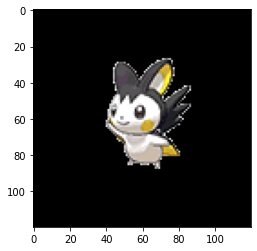

In [0]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks/')
with open('pokemon.pkl','rb') as f:
    X = pickle.load(f)

dataset = pd.read_csv('pokemon.csv')
#Only the png images and electric pokemon
img_format = dataset['Name'].apply(lambda x : x.split('.')[1])
X = X[dataset.loc[(img_format == 'png') & (dataset['Type1'] == 'Electric')].index]
Y = np.ones(X.shape[0])
X = X / 255. * 2 -1
print("x_train.shape: ", X.shape)

plt.imshow((X[1]+1)*0.5)

In [0]:
dataset['Type1'].unique()

array(['Water', 'Psychic', 'Ghost', 'Rock', 'Fire', 'Normal', 'Electric',
       'Ice', 'Ground', 'Bug', 'Dark', 'Dragon', 'Poison', 'Fighting',
       'Grass', 'Steel', 'Fairy', 'Flying'], dtype=object)

In [0]:
N, H, W, C = X.shape
D = H*W*C

In [0]:
def build_generator():
  i = Input(shape = (100, ))
  
  x = Dense(15*15*256)(i)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)

  x = Reshape((15, 15, 256))(x)
  #(15, 15, 256)

  x = Conv2DTranspose(128, (5,5), strides=(1,1), padding='same')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)
  #(15, 15, 128)

  x = Conv2DTranspose(64, (5,5), strides=(2,2), padding='same')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)
  #(30, 30, 64)

  x = Conv2DTranspose(32, (5,5), strides=(2,2), padding='same')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU()(x)
  #(60, 60, 64)

  x = Conv2DTranspose(3, (5,5), strides=(2,2), padding='same')(x)
  #(120, 120, 3)

  '''x = tf.subtract(x, tf.reduce_min(x))
  x = tf.divide(x, tf.reduce_max(x));
  x = tf.multiply(x, tf.constant(2.))
  x = tf.subtract(x, tf.constant(1.))'''
  
  model = Model(i, x)
  return model


In [0]:
def build_discriminator():
  i = Input(shape = (H, W, C))

  x = Conv2D(64, (5, 5), strides=(2,2), padding='same')(i)
  x = LeakyReLU()(x)
  x = Dropout(0.3)(x)

  x = Conv2D(128, (5, 5), strides=(2,2), padding='same')(x)
  x = LeakyReLU()(x)
  x = Dropout(0.3)(x)

  x = Flatten()(x)
  x = Dense(1, activation='sigmoid')(x)

  model = Model(i, x)
  return model

In [0]:
discriminator  = build_discriminator()
discriminator.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(2e-4, 0.5),
    metrics=['accuracy']
)

generator = build_generator()

z = Input(shape = (100, ))

img = generator(z)

discriminator.trainable = False

fake_pred = discriminator(img)

combined_model = Model(z, fake_pred)

combined_model.compile(
    loss = 'binary_crossentropy',
    optimizer=Adam(2e-4, 0.5)
    )


In [0]:
batch_size = 20
epochs = 10000
sample_period = 200

ones = np.ones(batch_size)
zeros = np.zeros(batch_size)

d_losses = []
g_losses = []

if not os.path.exists('gan_images'):
  os.makedirs('gan_images')

In [0]:
def sample_images(epoch):
  rows, cols = 3, 3
  noise = np.random.randn(rows*cols, 100)
  imgs = generator.predict(noise)
  imgs = imgs - imgs.min()
  imgs = imgs / imgs.max()
  fig, axs = plt.subplots(rows, cols)
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx])
      axs[i,j].axis('off')
      idx += 1
  
  #plt.show()
  fig.savefig("gan_images/%d.png"%epoch)
  generator.save('g_model.h5')
  plt.close()

In [0]:
for epoch in range(epochs):
  idx = np.random.randint(0, X.shape[0], batch_size)
  real_imgs = X[idx]
  
  noise = np.random.randn(batch_size, 100)
  fake_imgs = generator.predict(noise)

  #data_generator = tf.keras.preprocessing.image.ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
  #train_generator = data_generator.flow(real_imgs, Y, batch_size)

  d_loss_real, d_acc_real = discriminator.train_on_batch(real_imgs, ones)
  d_loss_fake, d_acc_fake = discriminator.train_on_batch(fake_imgs, zeros)

  d_loss = 0.5 * (d_loss_real + d_loss_fake)
  d_acc = 0.5 * (d_acc_real + d_acc_fake)

  noise = np.random.randn(batch_size, 100)
  g_loss = combined_model.train_on_batch(noise, ones)

  noise = np.random.randn(batch_size, 100)
  g_loss = combined_model.train_on_batch(noise, ones)

  noise = np.random.randn(batch_size, 100)
  g_loss = combined_model.train_on_batch(noise, ones)

  d_losses.append(d_loss)
  g_losses.append(g_loss)

  if epoch % 100 == 0:
    print(f"epoch: {epoch+1}/{epochs}, d_loss: {d_loss:.2f} - d_acc: {d_acc:.2f}\
    g_loss: {g_loss:.2f}")

  if epoch % sample_period == 0:
    sample_images(epoch)




epoch: 1/10000, d_loss: 0.69 - d_acc: 0.20    g_loss: 0.33
epoch: 101/10000, d_loss: 0.00 - d_acc: 1.00    g_loss: 0.00
epoch: 201/10000, d_loss: 0.93 - d_acc: 0.08    g_loss: 0.55
epoch: 301/10000, d_loss: 0.72 - d_acc: 0.47    g_loss: 0.18
epoch: 401/10000, d_loss: 0.78 - d_acc: 0.22    g_loss: 0.54
epoch: 501/10000, d_loss: 0.74 - d_acc: 0.38    g_loss: 0.77
epoch: 601/10000, d_loss: 0.73 - d_acc: 0.40    g_loss: 0.77
epoch: 701/10000, d_loss: 0.70 - d_acc: 0.42    g_loss: 0.76
epoch: 801/10000, d_loss: 0.67 - d_acc: 0.47    g_loss: 0.75
epoch: 901/10000, d_loss: 0.64 - d_acc: 0.80    g_loss: 0.75
epoch: 1001/10000, d_loss: 0.65 - d_acc: 0.70    g_loss: 0.99
epoch: 1101/10000, d_loss: 0.62 - d_acc: 0.80    g_loss: 0.87
epoch: 1201/10000, d_loss: 0.57 - d_acc: 0.78    g_loss: 0.95
epoch: 1301/10000, d_loss: 0.57 - d_acc: 0.77    g_loss: 1.08
epoch: 1401/10000, d_loss: 0.53 - d_acc: 0.88    g_loss: 0.99
epoch: 1501/10000, d_loss: 0.58 - d_acc: 0.78    g_loss: 1.02
epoch: 1601/10000, d

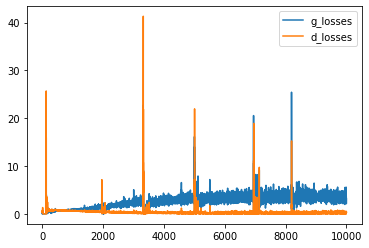

In [0]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

In [0]:
from skimage.io import imread
for epoch in range(0,epochs+1000, 1000):
  a = imread('gan_image/%d.png'%epoch)
  plt.imshow(a)
  plt.show()
